# Phase 2 EDA (Project-Driven, Explained) — EO3 / IRS Nonprofit Dataset

## Phase 2 goal (what we are answering now)
Phase 1 established **structure and trust** (scope, missingness, distributions).  
Phase 2 moves into **insight** using EO3-only data (no API):

1) **Sector insight (NTEE):** Which nonprofit sectors have more/fewer organizations and how do financial scales differ?  
2) **Geography insight (STATE):** Where are organizations concentrated and how does financial capacity differ by state?  
3) **Concentration insight:** How much of total revenue/assets is held by the largest organizations?

✅ **Deliverables from Phase 2**
- A **sector summary table** (NTEE) with funding gap metrics
- A **state summary table**
- A **concentration metrics table** (top 1%, 5%, 10% shares)
- Optional charts (you can keep in Python now and recreate in Tableau later)

> **Note:** We are still not doing causality or predictions. This is descriptive, decision-support EDA.


In [1]:
# 0) Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)


## 1) Load data

### What this step does
Loads the cleaned EO3 dataset into `df`.

### Why this matters
We want Phase 2 insights to be reproducible on the full EO3 file (not just samples).

### If you switch to the raw 160MB file later
Just change `DATA_PATH` below; the notebook logic stays the same.


In [2]:
DATA_PATH = "/Users/ashishsharma/CSUEB/volunteer_mvp/data/raw/eo3.csv"  # change to your EO3 raw/clean file path
df = pd.read_csv(DATA_PATH)

print("Loaded shape:", df.shape)
df.head()


Loaded shape: (937702, 28)


,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME
0,260049,CORINTH BAPTIST CHURCH,NaN,PO BOX 92,HOSFORD,FL,32334-0092,2024,3,9,7200,196908,1,10,59029000,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN
1,360268,IGLESIA VICTORIA,NaN,1445 N BOONVILLE AVE,SPRINGFIELD,MO,65802-1894,1678,3,9,7000,196408,1,10,1002029,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN
2,490336,EASTSIDE BAPTIST CHURCH,NaN,PO BOX 296,LABELLE,FL,33975-0296,2024,3,9,7200,196908,1,10,59029000,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN
3,2296179,RELIGIOUS SCIENCE CHURCH CENTER OF SAN DIEGO,NaN,4102 MARLBOROUGH,SAN DIEGO,CA,92105-1462,0,3,3,7000,196204,1,10,1000000,1,1,NaN,0,0,6,0,3,NaN,NaN,NaN,NaN,NaN
4,3140260,PILGRIM BAPTIST CHURCH,NaN,20615 STANTON AVE,CASTRO VALLEY,CA,94546-0000,3125,3,9,7000,195504,1,10,1000000,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,4574 CASTRO VALLEY


## 2) Quick sanity checks (duplicates + key columns)

### Why we do this
Sector/state totals can be distorted if duplicates exist or key columns are missing.

### What to interpret
- Duplicate count should be 0 (or close to 0 if dataset includes multiple filings you intend to keep).
- Confirm expected columns exist before proceeding.


In [3]:
dup_count = df.duplicated().sum()
print("Exact duplicate rows:", dup_count)

expected_cols = ["EIN", "STATE", "NTEE_CD", "REVENUE_AMT", "ASSET_AMT", "INCOME_AMT"]
print("\nExpected columns present?")
for c in expected_cols:
    print(f"{c:>12}: {c in df.columns}")


Exact duplicate rows: 0

Expected columns present?
         EIN: True
       STATE: True
     NTEE_CD: True
 REVENUE_AMT: True
   ASSET_AMT: True
  INCOME_AMT: True


## 3) Phase 2A — Sector analysis (NTEE)

### Why this is important
NTEE codes classify nonprofits by mission/sector. This lets you answer:
- Which sectors are most common?
- Which sectors have the greatest total reported revenue/assets?
- Which sectors appear **over/under-resourced** relative to their org counts?

### Two useful levels
1) **NTEE_CD** (full code, e.g., `P30`) → detailed sub-sector  
2) **NTEE letter** (first character, e.g., `P`) → broader sector buckets

### Key metrics we compute
- `org_count` (how many org records per sector)
- `total_revenue` (sum of reported revenue)
- `median_revenue` (typical org revenue; more robust than mean)
- `revenue_share_pct` vs `org_share_pct`
- `funding_gap_pct` = revenue_share_pct − org_share_pct  
  - positive → sector has larger revenue share than its org share  
  - negative → sector has smaller revenue share than its org share


In [4]:
def safe_div(numer, denom):
    return np.where(denom == 0, np.nan, numer / denom)

def pct(x):
    return (x * 100).round(2)


In [5]:
# 3A.1 Sector summary by full NTEE_CD
sector_df = (
    df.groupby("NTEE_CD", dropna=False)
      .agg(
          org_count=("EIN", "count"),
          total_revenue=("REVENUE_AMT", "sum"),
          total_assets=("ASSET_AMT", "sum"),
          total_income=("INCOME_AMT", "sum"),
          median_revenue=("REVENUE_AMT", "median"),
          mean_revenue=("REVENUE_AMT", "mean"),
      )
      .reset_index()
)

sector_df["revenue_per_org"] = safe_div(sector_df["total_revenue"], sector_df["org_count"])
sector_df["assets_per_org"]  = safe_div(sector_df["total_assets"], sector_df["org_count"])

total_rev_all = sector_df["total_revenue"].sum(skipna=True)
total_orgs_all = sector_df["org_count"].sum()

sector_df["revenue_share_pct"] = pct(safe_div(sector_df["total_revenue"], total_rev_all))
sector_df["org_share_pct"]     = pct(safe_div(sector_df["org_count"], total_orgs_all))
sector_df["funding_gap_pct"]   = (sector_df["revenue_share_pct"] - sector_df["org_share_pct"]).round(2)

sector_df.head()


,NTEE_CD,org_count,total_revenue,total_assets,total_income,median_revenue,mean_revenue,revenue_per_org,assets_per_org,revenue_share_pct,org_share_pct,funding_gap_pct
0,0000,2,232805.0,25584.0,232805.0,116402.5,116402.5,116402.5,12792.0,0.0,0.0,0.0
1,050,1,0.0,0.0,126000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,890,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A00A,1,84435.0,17656.0,86392.0,84435.0,84435.0,84435.0,17656.0,0.0,0.0,0.0
4,A00J,2,0.0,1294.0,123016.0,0.0,0.0,0.0,647.0,0.0,0.0,0.0


### How to interpret the sector table
- Look at **org_count** to see which sectors dominate by count.
- Look at **total_revenue** and **median_revenue** to understand “scale”.
- Look at **funding_gap_pct** to see over/under-resourcing patterns.

Next we create a **top/bottom** view to make the story easier.


In [6]:
TOP_K = 15

top_by_count = sector_df.sort_values("org_count", ascending=False).head(TOP_K)
top_by_revenue = sector_df.sort_values("total_revenue", ascending=False).head(TOP_K)
top_gap = sector_df.sort_values("funding_gap_pct", ascending=False).head(TOP_K)
bottom_gap = sector_df.sort_values("funding_gap_pct", ascending=True).head(TOP_K)

print("Top sectors by org_count:")
display(top_by_count)

print("\nTop sectors by total_revenue:")
display(top_by_revenue)

print("\nTop sectors by funding_gap_pct:")
display(top_gap)

print("\nBottom sectors by funding_gap_pct:")
display(bottom_gap)


Top sectors by org_count:


,NTEE_CD,org_count,total_revenue,total_assets,total_income,median_revenue,mean_revenue,revenue_per_org,assets_per_org,revenue_share_pct,org_share_pct,funding_gap_pct
3977,NaN,264051,2.825227e+11,1.011786e+12,3.809293e+11,0.0,1.772513e+06,1.069955e+06,3.831782e+06,17.74,28.16,-10.42
3778,X20,55239,4.451788e+09,7.744622e+09,5.848099e+09,0.0,2.078430e+05,8.059140e+04,1.402021e+05,0.28,5.89,-5.61
2658,P20,28245,8.515555e+09,2.526363e+10,1.097010e+10,0.0,3.634932e+05,3.014889e+05,8.944460e+05,0.53,3.01,-2.48
3800,X21,23335,1.219410e+09,2.201115e+09,1.805209e+09,0.0,2.611716e+05,5.225670e+04,9.432676e+04,0.08,2.49,-2.41
2553,O50,14096,2.085533e+09,2.828955e+09,2.394859e+09,0.0,1.866917e+05,1.479521e+05,2.006920e+05,0.13,1.50,-1.37
910,D20,13520,1.645522e+09,3.309397e+09,2.335883e+09,0.0,1.432632e+05,1.217102e+05,2.447779e+05,0.10,1.44,-1.34
3324,T20,12052,5.571084e+08,1.746505e+11,6.856220e+10,13772.5,6.712149e+05,4.622539e+04,1.449141e+07,0.03,1.29,-1.26
649,B82,11509,2.642240e+09,2.198481e+10,7.117184e+09,0.0,2.942033e+05,2.295803e+05,1.910228e+06,0.17,1.23,-1.06
682,B90,11363,2.951075e+09,5.437606e+09,3.707953e+09,0.0,3.396725e+05,2.597091e+05,4.785361e+05,0.19,1.21,-1.02
3343,T22,9503,3.506386e+08,1.955278e+11,4.592170e+10,21916.0,1.157223e+06,3.689767e+04,2.057537e+07,0.02,1.01,-0.99



Top sectors by total_revenue:


,NTEE_CD,org_count,total_revenue,total_assets,total_income,median_revenue,mean_revenue,revenue_per_org,assets_per_org,revenue_share_pct,org_share_pct,funding_gap_pct
3977,NaN,264051,2.825227e+11,1.011786e+12,3.809293e+11,0.000000e+00,1.772513e+06,1.069955e+06,3.831782e+06,17.74,28.16,-10.42
1062,E220,435,2.199215e+11,2.758195e+11,2.431709e+11,3.094612e+08,5.787407e+08,5.055666e+08,6.340678e+08,13.81,0.05,13.76
1089,E310,10,1.066739e+11,5.293615e+10,1.232172e+11,4.484971e+09,1.185266e+10,1.066739e+10,5.293615e+09,6.70,0.00,6.70
1055,E210,103,9.778473e+10,2.248590e+11,1.251882e+11,1.520679e+08,1.062877e+09,9.493663e+08,2.183097e+09,6.14,0.01,6.13
547,B430,117,6.961379e+10,2.221963e+11,1.057751e+11,1.584685e+08,6.328527e+08,5.949897e+08,1.899114e+09,4.37,0.01,4.36
1046,E20,407,3.973398e+10,5.262276e+10,4.961539e+10,4.604068e+06,1.370137e+08,9.762649e+07,1.292943e+08,2.50,0.04,2.46
1074,E240,54,3.872467e+10,8.104983e+10,4.557657e+10,4.010844e+08,8.605482e+08,7.171235e+08,1.500923e+09,2.43,0.01,2.42
1054,E21,373,3.432185e+10,6.442754e+10,5.848676e+10,2.342420e+05,1.151740e+08,9.201567e+07,1.727280e+08,2.16,0.04,2.12
1061,E22,316,3.242904e+10,4.193375e+10,4.023123e+10,1.580956e+07,1.409958e+08,1.026236e+08,1.327017e+08,2.04,0.03,2.01
507,B29,1704,1.734161e+10,2.435775e+10,1.767405e+10,4.942918e+06,1.092041e+07,1.017700e+07,1.429445e+07,1.09,0.18,0.91



Top sectors by funding_gap_pct:


,NTEE_CD,org_count,total_revenue,total_assets,total_income,median_revenue,mean_revenue,revenue_per_org,assets_per_org,revenue_share_pct,org_share_pct,funding_gap_pct
1062,E220,435,2.199215e+11,2.758195e+11,2.431709e+11,3.094612e+08,5.787407e+08,5.055666e+08,6.340678e+08,13.81,0.05,13.76
1089,E310,10,1.066739e+11,5.293615e+10,1.232172e+11,4.484971e+09,1.185266e+10,1.066739e+10,5.293615e+09,6.70,0.00,6.70
1055,E210,103,9.778473e+10,2.248590e+11,1.251882e+11,1.520679e+08,1.062877e+09,9.493663e+08,2.183097e+09,6.14,0.01,6.13
547,B430,117,6.961379e+10,2.221963e+11,1.057751e+11,1.584685e+08,6.328527e+08,5.949897e+08,1.899114e+09,4.37,0.01,4.36
1046,E20,407,3.973398e+10,5.262276e+10,4.961539e+10,4.604068e+06,1.370137e+08,9.762649e+07,1.292943e+08,2.50,0.04,2.46
1074,E240,54,3.872467e+10,8.104983e+10,4.557657e+10,4.010844e+08,8.605482e+08,7.171235e+08,1.500923e+09,2.43,0.01,2.42
1054,E21,373,3.432185e+10,6.442754e+10,5.848676e+10,2.342420e+05,1.151740e+08,9.201567e+07,1.727280e+08,2.16,0.04,2.12
1061,E22,316,3.242904e+10,4.193375e+10,4.023123e+10,1.580956e+07,1.409958e+08,1.026236e+08,1.327017e+08,2.04,0.03,2.01
1080,E30,617,1.709199e+10,1.085671e+10,1.747721e+10,1.798170e+05,3.079638e+07,2.770177e+07,1.759596e+07,1.07,0.07,1.00
507,B29,1704,1.734161e+10,2.435775e+10,1.767405e+10,4.942918e+06,1.092041e+07,1.017700e+07,1.429445e+07,1.09,0.18,0.91



Bottom sectors by funding_gap_pct:


,NTEE_CD,org_count,total_revenue,total_assets,total_income,median_revenue,mean_revenue,revenue_per_org,assets_per_org,revenue_share_pct,org_share_pct,funding_gap_pct
3977,NaN,264051,2.825227e+11,1.011786e+12,3.809293e+11,0.0,1.772513e+06,1.069955e+06,3.831782e+06,17.74,28.16,-10.42
3778,X20,55239,4.451788e+09,7.744622e+09,5.848099e+09,0.0,2.078430e+05,8.059140e+04,1.402021e+05,0.28,5.89,-5.61
2658,P20,28245,8.515555e+09,2.526363e+10,1.097010e+10,0.0,3.634932e+05,3.014889e+05,8.944460e+05,0.53,3.01,-2.48
3800,X21,23335,1.219410e+09,2.201115e+09,1.805209e+09,0.0,2.611716e+05,5.225670e+04,9.432676e+04,0.08,2.49,-2.41
2553,O50,14096,2.085533e+09,2.828955e+09,2.394859e+09,0.0,1.866917e+05,1.479521e+05,2.006920e+05,0.13,1.50,-1.37
910,D20,13520,1.645522e+09,3.309397e+09,2.335883e+09,0.0,1.432632e+05,1.217102e+05,2.447779e+05,0.10,1.44,-1.34
3324,T20,12052,5.571084e+08,1.746505e+11,6.856220e+10,13772.5,6.712149e+05,4.622539e+04,1.449141e+07,0.03,1.29,-1.26
649,B82,11509,2.642240e+09,2.198481e+10,7.117184e+09,0.0,2.942033e+05,2.295803e+05,1.910228e+06,0.17,1.23,-1.06
682,B90,11363,2.951075e+09,5.437606e+09,3.707953e+09,0.0,3.396725e+05,2.597091e+05,4.785361e+05,0.19,1.21,-1.02
3343,T22,9503,3.506386e+08,1.955278e+11,4.592170e+10,21916.0,1.157223e+06,3.689767e+04,2.057537e+07,0.02,1.01,-0.99


## 3B) Sector summary by NTEE letter (broader sector buckets)

### Why we do this
Full NTEE_CD can be very granular and noisy. The **first letter** provides a stakeholder-friendly sector grouping.


In [7]:
# Create broader sector bucket
df["NTEE_SECTOR"] = df["NTEE_CD"].astype(str).str.strip().str[0]
df.loc[df["NTEE_CD"].isna(), "NTEE_SECTOR"] = np.nan

sector_letter_df = (
    df.groupby("NTEE_SECTOR", dropna=False)
      .agg(
          org_count=("EIN", "count"),
          total_revenue=("REVENUE_AMT", "sum"),
          total_assets=("ASSET_AMT", "sum"),
          total_income=("INCOME_AMT", "sum"),
          median_revenue=("REVENUE_AMT", "median"),
          mean_revenue=("REVENUE_AMT", "mean"),
      )
      .reset_index()
)

sector_letter_df["revenue_per_org"] = safe_div(sector_letter_df["total_revenue"], sector_letter_df["org_count"])

total_rev_all2 = sector_letter_df["total_revenue"].sum(skipna=True)
total_orgs_all2 = sector_letter_df["org_count"].sum()

sector_letter_df["revenue_share_pct"] = pct(safe_div(sector_letter_df["total_revenue"], total_rev_all2))
sector_letter_df["org_share_pct"]     = pct(safe_div(sector_letter_df["org_count"], total_orgs_all2))
sector_letter_df["funding_gap_pct"]   = (sector_letter_df["revenue_share_pct"] - sector_letter_df["org_share_pct"]).round(2)

sector_letter_df.sort_values("org_count", ascending=False)


,NTEE_SECTOR,org_count,total_revenue,total_assets,total_income,median_revenue,mean_revenue,revenue_per_org,revenue_share_pct,org_share_pct,funding_gap_pct
29,NaN,264051,2.825227e+11,1.011786e+12,3.809293e+11,0.0,1.772513e+06,1.069955e+06,17.74,28.16,-10.42
25,X,109019,1.626224e+10,5.802099e+10,3.924749e+10,0.0,3.865979e+05,1.491689e+05,1.02,11.63,-10.61
3,B,90782,1.933055e+11,6.021992e+11,2.822123e+11,0.0,2.539717e+06,2.129337e+06,12.14,9.68,2.46
17,P,79329,8.586293e+10,1.359396e+11,1.014443e+11,0.0,1.297748e+06,1.082365e+06,5.39,8.46,-3.07
2,A,55080,2.139580e+10,7.930008e+10,3.129210e+10,0.0,4.507416e+05,3.884496e+05,1.34,5.87,-4.53
15,N,51061,1.365057e+10,2.211751e+10,1.752289e+10,0.0,3.229452e+05,2.673385e+05,0.86,5.45,-4.59
21,T,49383,4.817789e+10,7.406333e+11,3.960542e+11,0.0,2.564018e+06,9.755967e+05,3.03,5.27,-2.24
20,S,33745,1.467974e+10,3.584622e+10,1.796264e+10,0.0,4.975172e+05,4.350197e+05,0.92,3.60,-2.68
16,O,26395,1.069962e+10,1.403810e+10,1.224294e+10,0.0,5.028016e+05,4.053653e+05,0.67,2.81,-2.14
5,D,22215,8.254121e+09,1.930095e+10,1.149583e+10,0.0,4.365181e+05,3.715562e+05,0.52,2.37,-1.85


## 4) Phase 2B — Geography analysis (STATE)

### Why this is important
Stakeholders often ask “where are these organizations located?” and “which regions have more resources?”

### What we compute per state
- org_count
- total revenue/assets/income (reported)
- medians (typical org scale)
- revenue_per_org (simple normalization)


In [8]:
state_df = (
    df.groupby("STATE", dropna=False)
      .agg(
          org_count=("EIN", "count"),
          total_revenue=("REVENUE_AMT", "sum"),
          total_assets=("ASSET_AMT", "sum"),
          total_income=("INCOME_AMT", "sum"),
          median_revenue=("REVENUE_AMT", "median"),
          median_assets=("ASSET_AMT", "median"),
      )
      .reset_index()
)

state_df["revenue_per_org"] = safe_div(state_df["total_revenue"], state_df["org_count"])

print("Top states by org_count:")
display(state_df.sort_values("org_count", ascending=False).head(15))

print("\nTop states by total_revenue:")
display(state_df.sort_values("total_revenue", ascending=False).head(15))


Top states by org_count:


,STATE,org_count,total_revenue,total_assets,total_income,median_revenue,median_assets,revenue_per_org
4,CA,198290,4.962397e+11,1.220535e+12,7.304262e+11,0.0,1.0,2.502596e+06
20,TX,149726,1.962300e+11,5.528523e+11,2.819925e+11,0.0,0.0,1.310594e+06
6,FL,110811,1.596696e+11,4.365202e+11,2.123132e+11,0.0,0.0,1.440918e+06
7,GA,60806,1.041066e+11,2.342682e+11,1.354138e+11,0.0,0.0,1.712111e+06
12,MO,43587,1.033452e+11,2.179327e+11,1.338461e+11,0.0,0.0,2.371009e+06
22,WA,41795,1.014021e+11,3.542511e+11,3.009178e+11,0.0,0.0,2.426177e+06
19,TN,39388,6.180698e+10,1.517093e+11,7.956028e+10,0.0,0.0,1.569183e+06
5,CO,35542,5.393329e+10,1.702667e+11,7.277578e+10,0.0,1.0,1.517452e+06
3,AZ,30505,5.286727e+10,1.016372e+11,6.130331e+10,0.0,0.0,1.733069e+06
18,OR,26445,4.129121e+10,1.027613e+11,5.052146e+10,0.0,0.0,1.561400e+06



Top states by total_revenue:


,STATE,org_count,total_revenue,total_assets,total_income,median_revenue,median_assets,revenue_per_org
4,CA,198290,4.962397e+11,1.220535e+12,7.304262e+11,0.0,1.0,2.502596e+06
20,TX,149726,1.962300e+11,5.528523e+11,2.819925e+11,0.0,0.0,1.310594e+06
6,FL,110811,1.596696e+11,4.365202e+11,2.123132e+11,0.0,0.0,1.440918e+06
7,GA,60806,1.041066e+11,2.342682e+11,1.354138e+11,0.0,0.0,1.712111e+06
12,MO,43587,1.033452e+11,2.179327e+11,1.338461e+11,0.0,0.0,2.371009e+06
22,WA,41795,1.014021e+11,3.542511e+11,3.009178e+11,0.0,0.0,2.426177e+06
19,TN,39388,6.180698e+10,1.517093e+11,7.956028e+10,0.0,0.0,1.569183e+06
5,CO,35542,5.393329e+10,1.702667e+11,7.277578e+10,0.0,1.0,1.517452e+06
3,AZ,30505,5.286727e+10,1.016372e+11,6.130331e+10,0.0,0.0,1.733069e+06
18,OR,26445,4.129121e+10,1.027613e+11,5.052146e+10,0.0,0.0,1.561400e+06


## 5) Phase 2C — Concentration metrics (Top 1%, 5%, 10% shares)

### Why this is important
Nonprofit financials are usually concentrated:
- A few very large organizations can dominate total revenue/assets.

### What we compute
For each financial metric:
- share of total held by top **1%**
- share of total held by top **5%**
- share of total held by top **10%**

This produces stakeholder-ready “concentration” statistics.


In [9]:
def top_share(series: pd.Series, frac: float) -> float:
    s = series.dropna()
    if len(s) == 0:
        return np.nan
    s_sorted = s.sort_values(ascending=False)
    n_top = max(1, int(np.floor(len(s_sorted) * frac)))
    return float(s_sorted.head(n_top).sum() / s_sorted.sum())


In [10]:
metrics = []
for col in ["REVENUE_AMT", "ASSET_AMT", "INCOME_AMT"]:
    if col not in df.columns:
        continue
    for frac in [0.01, 0.05, 0.10]:
        share = top_share(df[col], frac)
        metrics.append({
            "metric": col,
            "top_frac": frac,
            "share_of_total_pct": round(share * 100, 2) if pd.notna(share) else np.nan,
            "non_missing_count": int(df[col].notna().sum())
        })

concentration_df = pd.DataFrame(metrics)
concentration_df


,metric,top_frac,share_of_total_pct,non_missing_count
0,REVENUE_AMT,0.01,82.87,654460
1,REVENUE_AMT,0.05,95.03,654460
2,REVENUE_AMT,0.10,97.82,654460
3,ASSET_AMT,0.01,83.53,713073
4,ASSET_AMT,0.05,95.56,713073
5,ASSET_AMT,0.10,98.23,713073
6,INCOME_AMT,0.01,83.90,713073
7,INCOME_AMT,0.05,95.14,713073
8,INCOME_AMT,0.10,97.79,713073


## 6) Optional quick Python charts (skip if you already plotted)

These quick charts are useful for checking patterns in Python before recreating visuals in Tableau/Power BI.
- Sector funding gap (top/bottom)
- Top states by total revenue


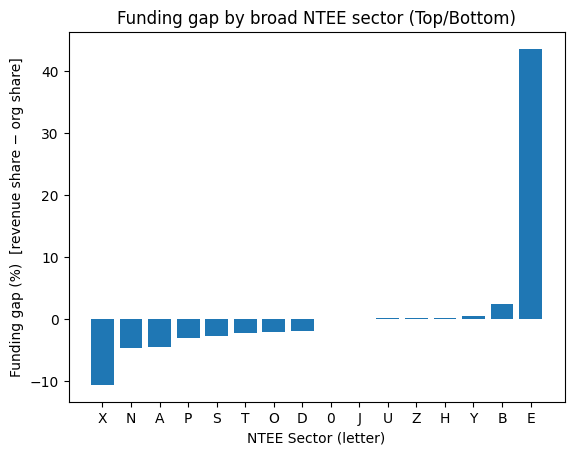

In [11]:
# Chart 1: Top/Bottom funding gap by NTEE sector letter (stakeholder-friendly)
tmp = sector_letter_df.dropna(subset=["NTEE_SECTOR"]).copy()
tmp = tmp.sort_values("funding_gap_pct", ascending=False)

top_n = 8
plot_df = pd.concat([tmp.head(top_n), tmp.tail(top_n)]).sort_values("funding_gap_pct")

plt.figure()
plt.bar(plot_df["NTEE_SECTOR"].astype(str), plot_df["funding_gap_pct"])
plt.xlabel("NTEE Sector (letter)")
plt.ylabel("Funding gap (%)  [revenue share − org share]")
plt.title("Funding gap by broad NTEE sector (Top/Bottom)")
plt.xticks(rotation=0)
plt.show()


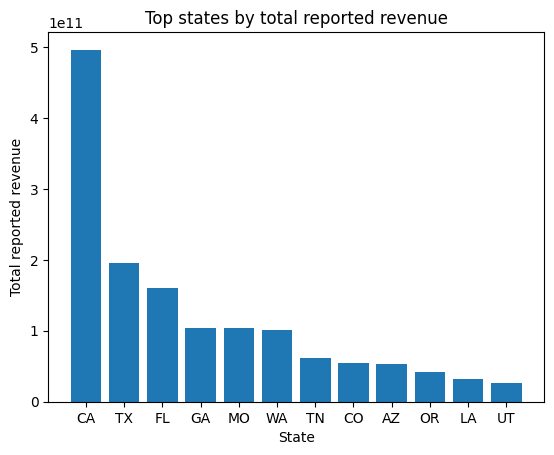

In [12]:
# Chart 2: Top states by total reported revenue
plot_states = state_df.dropna(subset=["STATE"]).sort_values("total_revenue", ascending=False).head(12)

plt.figure()
plt.bar(plot_states["STATE"].astype(str), plot_states["total_revenue"])
plt.xlabel("State")
plt.ylabel("Total reported revenue")
plt.title("Top states by total reported revenue")
plt.xticks(rotation=0)
plt.show()


## 7) Save Phase 2 outputs (CSV files)

### Why we do this
These output tables are your “analysis artifacts”:
- Easy to reuse in Tableau/Power BI
- Easy to share with stakeholders
- Easy to reference in a report

Files saved:
- `phase2_sector_analysis_by_ntee_cd.csv`
- `phase2_sector_analysis_by_ntee_letter.csv`
- `phase2_state_analysis.csv`
- `phase2_concentration_metrics.csv`


In [13]:
OUT_DIR = "phase2_outputs"

import os
os.makedirs(OUT_DIR, exist_ok=True)

sector_df.to_csv(os.path.join(OUT_DIR, "phase2_sector_analysis_by_ntee_cd.csv"), index=False)
sector_letter_df.to_csv(os.path.join(OUT_DIR, "phase2_sector_analysis_by_ntee_letter.csv"), index=False)
state_df.to_csv(os.path.join(OUT_DIR, "phase2_state_analysis.csv"), index=False)
concentration_df.to_csv(os.path.join(OUT_DIR, "phase2_concentration_metrics.csv"), index=False)

print("Saved outputs to:", OUT_DIR)


Saved outputs to: phase2_outputs


## 8) Phase 2 Findings (write your story here)

After running this notebook, write **5–8 stakeholder-ready bullets**.

### Suggested structure (copy/paste)
- **Sector composition:** The most common sectors by count are ___.
- **Sector scale:** Sectors differ greatly in median revenue/assets, indicating different “typical” organization sizes.
- **Funding gap:** Some sectors have a revenue share much larger/smaller than their organization share (funding gap).
- **Geography:** A small number of states dominate by count and/or total reported revenue.
- **Concentration:** The top 10% of organizations account for ___% of total reported revenue (and ___% of assets).
- **Data caveat:** Totals reflect *reported* values; missing financials mean totals may not represent all organizations equally.

### What Phase 3 could add (later)
- Geographic heatmaps (ZIP/state) without exposing exact addresses
- Sector × Geography intersection (which states lead within each sector)
- Deeper inequality metrics (Lorenz curve / Gini) if needed
